In [36]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os

In [37]:
import pandas as pd
import os

def load_and_process_csv(path, term_in_file='PMTrans'):
    # List to hold individual DataFrames with hierarchical indices
    dfs = []
    is_PMNN = term_in_file in ['wqq', 'tbqq']  # Check for PMNN cases
    is_PMNN_test = term_in_file in ['wqq_test', 'tbqq_test']  # Check for test variants

    # List all CSV files in the given directory
    for filename in os.listdir(path):
        # Only process files ending with '.csv' and matching the term_in_file conditions
        if filename.endswith('.csv') and term_in_file in filename:
            # Ensure that '_test' is not in filename when term_in_file is 'wqq' or 'tbqq'
            if (is_PMNN and '_test' not in filename) or is_PMNN_test or (term_in_file not in ['wqq', 'tbqq']):
                # Split the filename by '_'
                temp_filename = filename
                if 'wqq_test' in filename:
                    temp_filename = filename.replace('wqq_test', 'wqq-test')
                elif 'tbqq_test' in filename:
                    temp_filename = filename.replace('tbqq_test', 'tbqq-test')

                parts = temp_filename.split('_')

                if len(parts) == 9:
                    start_dim = 4
                else:
                    start_dim = 3

                if is_PMNN or is_PMNN_test:
                    start_dim += 1

                # Extract particle and jet information
                particle_geom = parts[start_dim]
                particle_dim = int(parts[start_dim + 1])
                if 'x' in particle_geom:
                    particle_dim *= 2

                if not (is_PMNN or is_PMNN_test):
                    jet_geom = parts[start_dim + 2]
                    jet_dim = int(parts[start_dim + 3])
                    if 'x' in jet_geom:
                        jet_dim *= 2

                # Load the CSV into a DataFrame
                df = pd.read_csv(os.path.join(path, filename))

                # Create a MultiIndex for this DataFrame
                if is_PMNN or is_PMNN_test:
                    index_tuples = [(particle_geom, particle_dim)] * len(df)
                    index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim'])
                else:
                    index_tuples = [(particle_geom, particle_dim, jet_geom, jet_dim)] * len(df)
                    index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])

                # Assign the MultiIndex to the DataFrame
                df.index = index

                # Append the DataFrame to the list
                dfs.append(df)
    
    # Concatenate all DataFrames into one, maintaining the hierarchical index
    combined_df = pd.concat(dfs)
    
    return combined_df


In [150]:
import matplotlib.pyplot as plt

def correct_string_to_latex(s):
    # Split the string by underscores to handle multiple terms
    terms = s.split('x')
    temp_str = ''
    # Transform each term into LaTeX format with superscripts
    latex_terms = []
    
    i = 0
    while i < len(terms):
        
        base = terms[i]
        latex_term = f"\\mathbb{{{base.capitalize()}}}"
        i = i + 1
        temp_str = temp_str + latex_term
        if len(terms) > i:
            temp_str = temp_str + ' \\times '
    
    # Join terms with the LaTeX product symbol if there are multiple terms
    latex_string = ' \\times '.join(latex_terms)
    
    return f"${temp_str}$"

def plot_highest_accuracies(df, 
                            variable_to_vary, 
                            metric_column='acc', 
                            filter_values=None, 
                            acc_range = None,
                            title = None,
                            PMNN = False):
    # Identify the columns that will remain constant
    if not PMNN:
        remaining_columns = ['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']
    else:
        remaining_columns = ['particle_geom', 'particle_dim']
        
    remaining_columns.remove(variable_to_vary)
    
    
    # If filtering values are provided, apply them to the DataFrame
    if filter_values:
        indexer = pd.IndexSlice
        for col, val in filter_values.items():
            df = df.loc[df.index.get_level_values(col) == val]

    # Group by the remaining columns and the variable_to_vary
    grouped = df.groupby(remaining_columns)
    
    # Plot each group
    plt.figure(figsize=(10, 8),facecolor='white')
    for name, group in grouped:
        if PMNN: 
            name = correct_string_to_latex(name)
            leg_title = 'Particle-Level Geom.'
        else:
            if 'particle_geom' in filter_values:
                name = correct_string_to_latex(name[-1]) 
                leg_title = 'Jet-Level Geom.'
            else:
                name = correct_string_to_latex(name[0]) 
                leg_title = 'Particle-Level Geom.'
                
        # Find the maximum accuracy for each unique value in the variable_to_vary column
        max_accuracy = group.groupby(variable_to_vary)[metric_column].max()
        
        # Plot the data
        plt.plot(max_accuracy.index, max_accuracy.values, marker='o', label=f"{name}")
    
    plt.xlabel(variable_to_vary)
    plt.ylabel('Highest Accuracy')
    if title is not None:
        plt.title(f'{title} accuracy with respect to {leg_title}')
    else:
        plt.title(f'Highest Accuracies with respect to {leg_title}')
        
    plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)
    plt.grid(True)
    plt.tight_layout()
    if acc_range is not None:
        plt.ylim(*acc_range)
    plt.show()


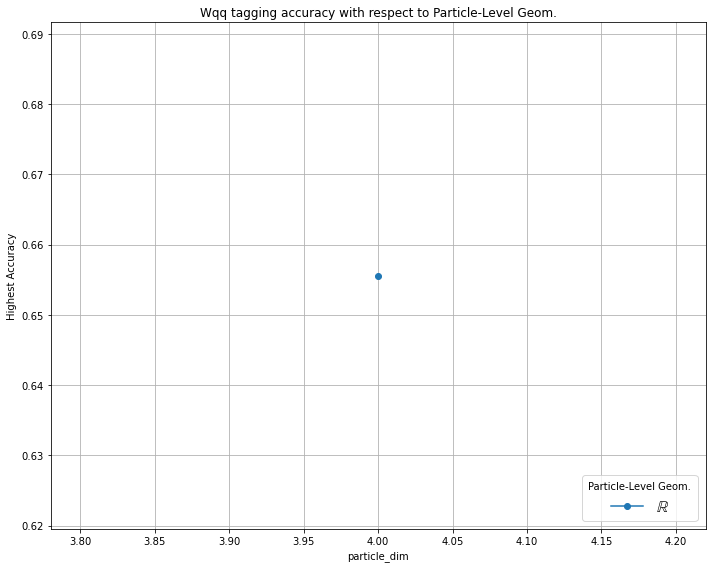

In [151]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path, term_in_file = 'wqq_test')
plot_highest_accuracies(combined_df,title = 'Wqq tagging', variable_to_vary='particle_dim',PMNN = True)

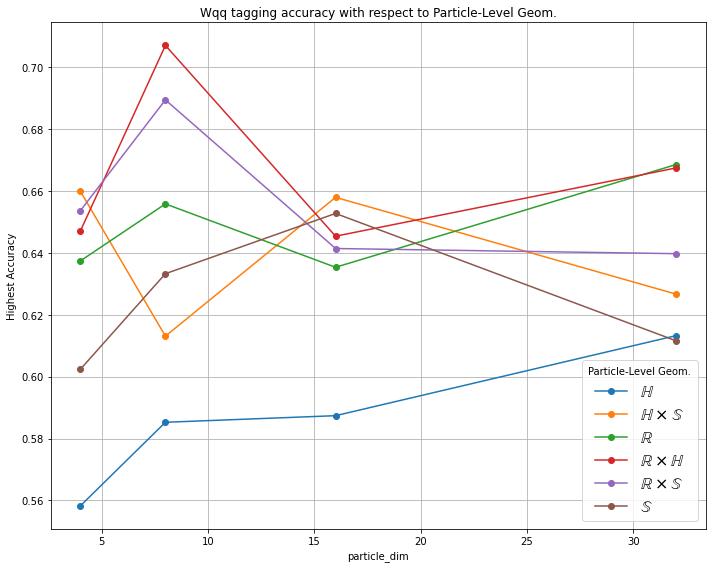

In [152]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path, term_in_file = 'wqq')
plot_highest_accuracies(combined_df,title = 'Wqq tagging', variable_to_vary='particle_dim',PMNN = True)

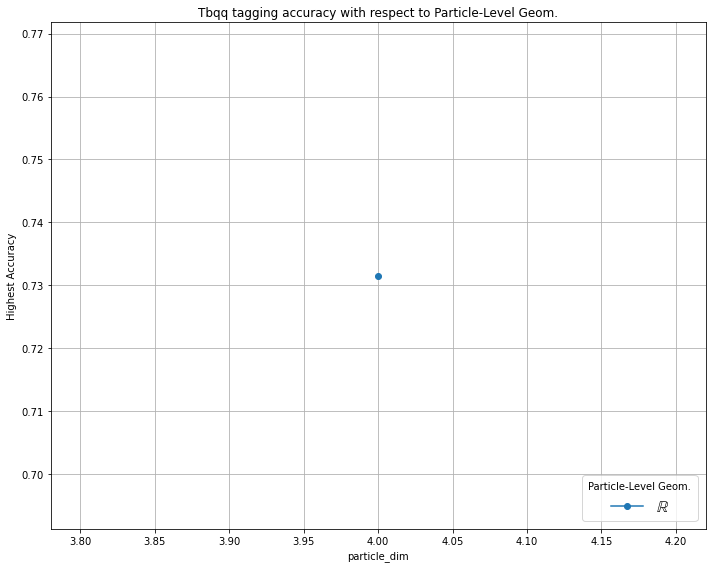

In [153]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path, term_in_file = 'tbqq_test')
plot_highest_accuracies(combined_df,title = 'Tbqq tagging', variable_to_vary='particle_dim',PMNN = True)

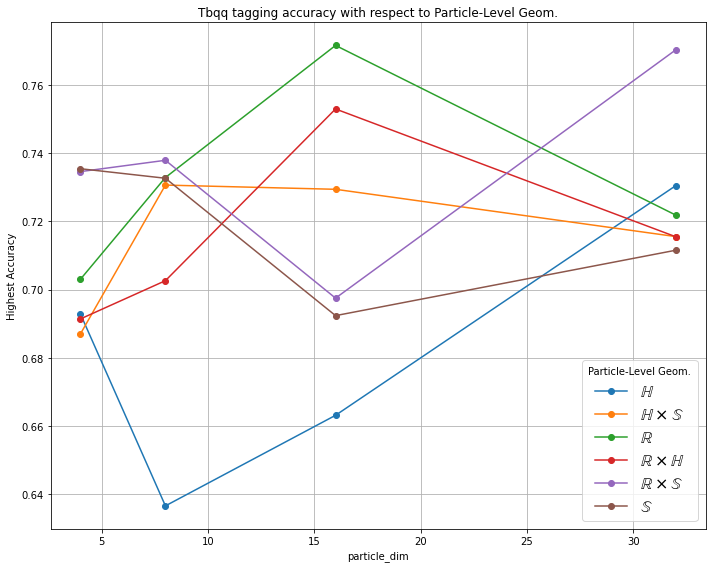

In [154]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path, term_in_file = 'tbqq')
plot_highest_accuracies(combined_df,title = 'Tbqq tagging', variable_to_vary='particle_dim',PMNN = True)

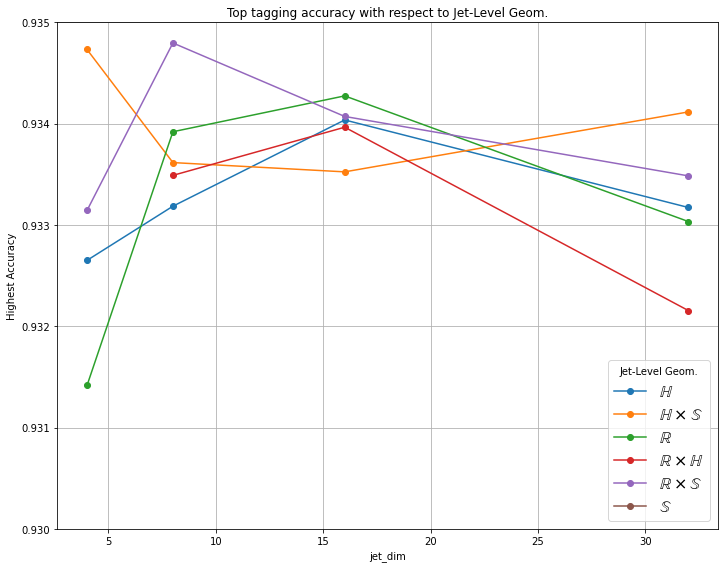

In [155]:
path = 'TopLandscape_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}
plot_highest_accuracies(combined_df,metric_column = 'test_acc',title = 'Top tagging', variable_to_vary='jet_dim', filter_values=filter_values, acc_range = [0.93,0.935])

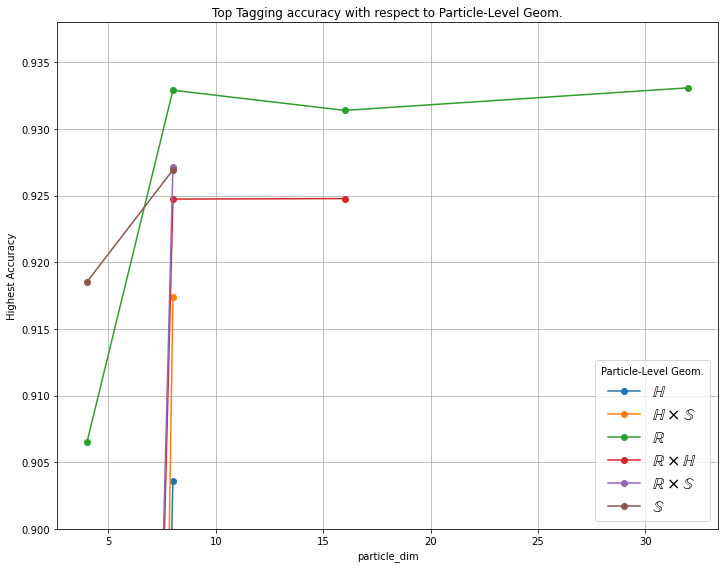

In [156]:
path = 'TopLandscape_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
plot_highest_accuracies(combined_df,title = 'Top Tagging', variable_to_vary='particle_dim',acc_range = [0.9,0.938], filter_values=filter_values)

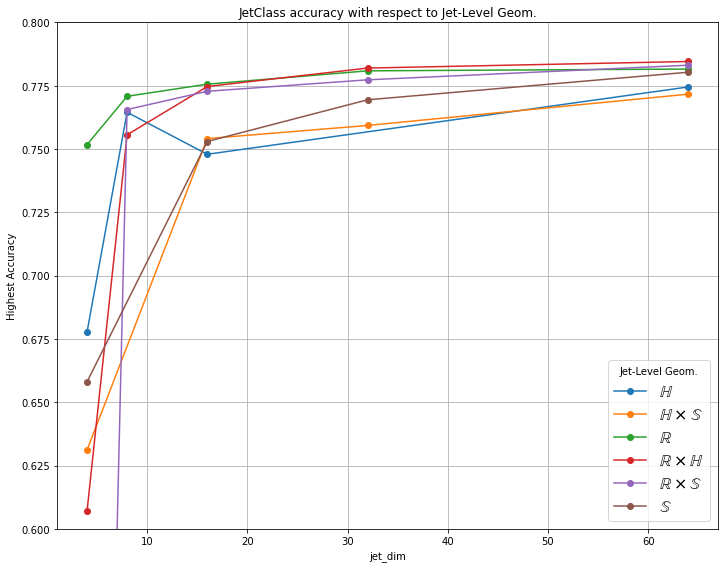

In [157]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}
plot_highest_accuracies(combined_df,title = 'JetClass', variable_to_vary='jet_dim',filter_values=filter_values,acc_range = [0.6,0.80])

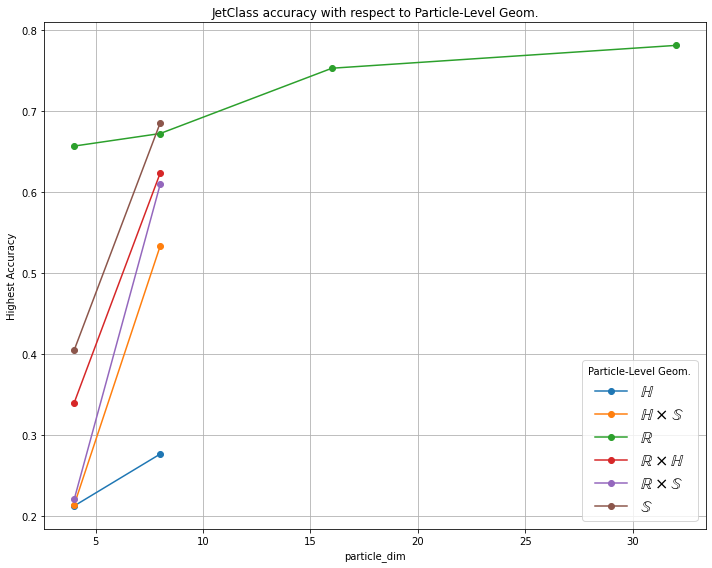

In [158]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 32
}
plot_highest_accuracies(combined_df, title = 'JetClass',variable_to_vary='particle_dim',filter_values=filter_values)

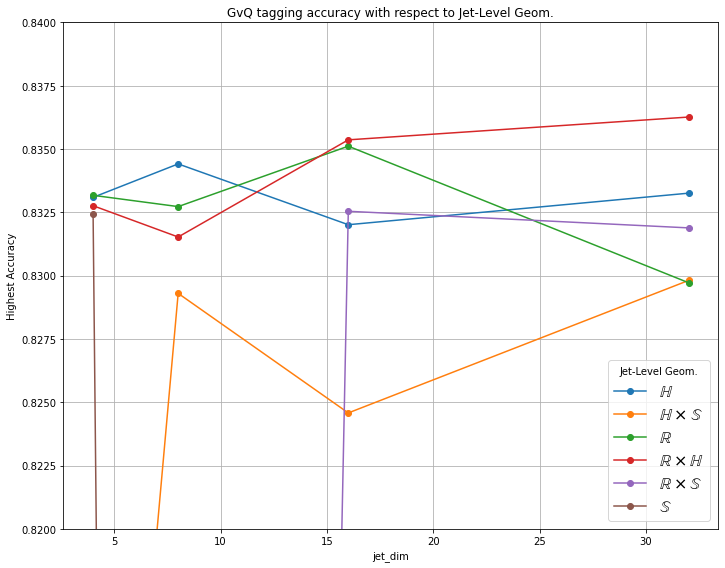

In [159]:
path = 'QuarkGluon_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}
plot_highest_accuracies(combined_df,metric_column = 'acc',title = 'GvQ tagging', variable_to_vary='jet_dim',filter_values=filter_values,acc_range=[0.82,0.84])

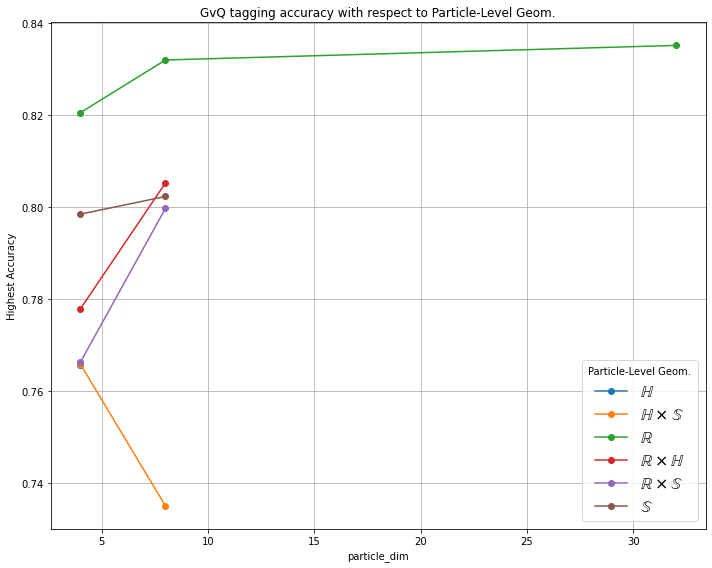

In [160]:
path = 'QuarkGluon_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
plot_highest_accuracies(combined_df,title = 'GvQ tagging', variable_to_vary='particle_dim', filter_values=filter_values)

In [161]:
# Function to calculate metrics for each class
def calculate_metrics(y_true, y_scores, target_tprs=[0.5, 0.7, 0.99]):
    unique_classes = np.unique(y_true)
    aucs = {}
    accuracies = {}
    rejections = {tpr: {} for tpr in target_tprs}
    fprs = {}
    tprs = {}

    for class_label in unique_classes:
        binary_y_true = (y_true == class_label).astype(int)
        y_score = y_scores[:, class_label]

        if len(np.unique(binary_y_true)) < 2:
            aucs[class_label] = None
            accuracies[class_label] = None
            for tpr in target_tprs:
                rejections[tpr][class_label] = None
            fprs[class_label] = None
            tprs[class_label] = None
            continue

        fpr, tpr, thresholds = roc_curve(binary_y_true, y_score)
        auc = roc_auc_score(binary_y_true, y_score)
        accuracy = accuracy_score(binary_y_true, y_score >= 0.5)
        
        rejections_for_class = {}
        for tpr_value in target_tprs:
            if tpr_value in tpr:
                target_index = np.where(tpr >= tpr_value)[0][0]
                target_fpr = fpr[target_index]
                rejections_for_class[tpr_value] = 1 / target_fpr if target_fpr != 0 else np.inf
            else:
                rejections_for_class[tpr_value] = None
        
        aucs[class_label] = auc
        accuracies[class_label] = accuracy
        for tpr in target_tprs:
            rejections[tpr][class_label] = rejections_for_class[tpr]
        
        # Check if fpr and tpr are lists before converting them
        fprs[class_label] = fpr.tolist() if isinstance(fpr, (list, np.ndarray)) else []
        tprs[class_label] = tpr.tolist() if isinstance(tpr, (list, np.ndarray)) else []

    return aucs, accuracies, rejections, fprs, tprs


In [3]:
import os
import uproot
import awkward as ak
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

signals = ['Hbb', 'Hcc', 'Hgg', 'H4q', 'Hqql', 'Tbqq', 'Tbl', 'Wqq', 'Zqq', 'QCD']

# Function to read data from ROOT file and convert to a Pandas DataFrame
def read_root_file(file_path):
    with uproot.open(file_path) as file:
        # Assuming the tree name is the first key in the file
        tree = file[file.keys()[0]]
        # Convert the tree to an awkward array
        data = tree.arrays(library='ak')
    # Convert the awkward array to an Arrow table, then to a Pandas DataFrame
    arrow_table = ak.to_arrow_table(data)
    return arrow_table.to_pandas()

# Function to calculate metrics for each class
def calculate_metrics(y_true, y_score, target_tprs=[0.3, 0.5, 0.7, 0.99]):
    if len(np.unique(y_true)) < 2:
        return None, None, {tpr: None for tpr in target_tprs}, None, None
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    accuracy = accuracy_score(y_true, y_score >= 0.5)
    
    rejections = {}
    for tpr_value in target_tprs:
        try:
            target_index = np.where(tpr >= tpr_value)[0][0]
            target_fpr = fpr[target_index]
            rejections[tpr_value] = 1 / target_fpr if target_fpr != 0 else np.inf
        except IndexError:
            rejections[tpr_value] = None
    
    return auc, accuracy, rejections, fpr.tolist(), tpr.tolist()

# Main function to process all files and return a DataFrame with metrics
def process_directory(directory_path='/n/holystore01/LABS/iaifi_lab/Lab/nswood/training/JetClass/Pythia/full/PMTrans'):
    results = []
    
    # Outer loop: iterate over subdirectories (each representing a model)
    for model_name in os.listdir(directory_path)[0:5]:
        model_path = os.path.join(directory_path, model_name, 'predict_output')
        print(model_name)
        if os.path.isdir(model_path):
            model_data = pd.DataFrame()  # DataFrame to hold combined data for this model
            preds = []  # List to store predictions
            labels = []  # List to store one-hot encoded labels
            
            # Inner loop: iterate over .root files in the model's subdirectory
            for root_file in os.listdir(model_path):
                if root_file.endswith('.root'):
                    file_path = os.path.join(model_path, root_file).head()
                    df = read_root_file(file_path)  # Read the root file
                    model_data = pd.concat([model_data, df], axis=0)
            
            score_cols = [col for col in model_data.columns if col.startswith('score_')]
            label_cols = [col for col in model_data.columns if col.startswith('label_')]
            score_columns = list(set(score_cols))
            label_columns = list(set(label_cols))
            
            for _, row in model_data.iterrows():
                # Add the predictions (scores) to preds list
                preds.append(row[score_columns].values.tolist())

                # One-hot encode the true label based on signals ordering
                true_label = row[label_columns].values.argmax()
                one_hot_label = [0] * len(signals)
                one_hot_label[true_label] = 1
                labels.append(one_hot_label)
            
            # Now preds contains all the predictions and labels contains all the one-hot encoded true labels
            # Convert lists to DataFrame
            results_df = pd.DataFrame({
                'preds': preds,
                'labels': labels
            })

            # Save the DataFrame for each model
            results_df['model_id'] = model_name
            results.append(results_df)

            # Calculate overall accuracy
            overall_accuracy = accuracy_score(np.argmax(labels, axis=1), np.argmax(preds, axis=1))
            print(f"Overall accuracy for model {model_name}: {overall_accuracy}")

    # Concatenate all results into a single DataFrame
    final_results_df = pd.concat(results, ignore_index=True)

    # Create the base_name column to filter by
    final_results_df['base_name'] = final_results_df['model_id'].apply(lambda x: ''.join(x.split('_batch256')[1:]))
    
    # Filter out models with lower accuracy if only the number ID varies
    filtered_df = final_results_df.sort_values('base_name').drop_duplicates('base_name', keep='first')
    filtered_df.set_index('base_name', inplace=True)

    return filtered_df

# Example usage:
# results_df = process_directory()

# Display the results
print(results_df)


AttributeError: partially initialized module 'awkward' has no attribute '_connect' (most likely due to a circular import)

In [3]:
score_columns

['score_label_QCD',
 'score_label_Hgg',
 'score_label_Hqql',
 'score_label_Tbqq',
 'score_label_Tbl',
 'score_label_Hbb',
 'score_label_Hcc',
 'score_label_Wqq',
 'score_label_H4q',
 'score_label_Zqq']

In [6]:
signals = ['Hbb', 'Hcc', 'Hgg', 'H4q', 'Hqql', 'Tbqq', 'Tbl', 'Wqq', 'Zqq', 'QCD']


['score_label_QCD',
 'score_label_Hgg',
 'score_label_Hqql',
 'score_label_Tbqq',
 'score_label_Tbl',
 'score_label_Hbb',
 'score_label_Hcc',
 'score_label_Wqq',
 'score_label_H4q',
 'score_label_Zqq']

In [34]:
import os
import uproot
import awkward as ak
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
def read_root_file(file_path):
    with uproot.open(file_path) as file:
        # Assuming the tree name is the first key in the file
        tree = file[file.keys()[0]]
        # Convert the tree to an awkward array
        data = tree.arrays(library='ak')
    # Convert the awkward array to an Arrow table, then to a Pandas DataFrame
    arrow_table = ak.to_arrow_table(data)
    return arrow_table.to_pandas()


directory_path='/n/holystore01/LABS/iaifi_lab/Lab/nswood/training/JetClass/Pythia/full/PMTrans'
results = []

# Outer loop: iterate over subdirectories (each representing a model)
for model_name in os.listdir(directory_path)[0:5]:
    model_path = os.path.join(directory_path, model_name, 'predict_output')
    print(model_name)
    if os.path.isdir(model_path):
        model_data = pd.DataFrame()  # DataFrame to hold combined data for this model
        preds = []  # List to store predictions
        labels = []  # List to store one-hot encoded labels

        # Inner loop: iterate over .root files in the model's subdirectory
        for root_file in os.listdir(model_path):
            if root_file.endswith('.root'):
                print(root_file)
                file_path = os.path.join(model_path, root_file)
                df = read_root_file(file_path) # Read the root file
                print(len(df))
                model_data = pd.concat([model_data, df], axis=0)

        score_cols = [f'score_label_{signal}' for signal in signals]
        label_cols = [f'label_{signal}' for signal in signals]

        # Ensure that only the relevant columns exist in model_data
        score_cols = [col for col in score_cols if col in model_data.columns]
        label_cols = [col for col in label_cols if col in model_data.columns]

        # Use DataFrame values to get predictions directly
        preds = model_data[score_cols].values.tolist()

        # One-hot encode true labels
        # Find the true label index for each row
        true_label_indices = model_data[label_cols].values.argmax(axis=1)

        # Convert indices to one-hot encoded format
        labels = np.eye(len(signals))[true_label_indices].tolist()



        # Now preds contains all the predictions and labels contains all the one-hot encoded true labels
        # Convert lists to DataFrame
        results_df = pd.DataFrame({
            'preds': preds,
            'labels': labels
        })

        # Save the DataFrame for each model
        results_df['model_id'] = model_name
        results.append(results_df)

        # Calculate overall accuracy
        overall_accuracy = accuracy_score(np.argmax(labels, axis=1), np.argmax(preds, axis=1))
        print(f"Overall accuracy for model {model_name}: {overall_accuracy}")
        break


20240825-051105_example_PMTransformer_rlion_lr0.0001_batch256PMTrans_R_32_H_32
20240824-025052_example_PMTransformer_rlion_lr0.0001_batch256PMTrans_S_4_R_32
pred_TTBarLep.root
2000000
pred_HToGG.root
2000000


KeyboardInterrupt: 

In [53]:
results_df = pd.read_csv('JetClass_processed_performance.csv')

In [55]:
results_df

,model_id,overall_accuracy,base_name,Tbqq_auc,Tbqq_accuracy,Tbqq_rejection_30_mean,Tbqq_rejection_30_std,Tbqq_rejection_50_mean,Tbqq_rejection_50_std,Tbqq_rejection_70_mean,...,Zqq_auc,Zqq_accuracy,Zqq_rejection_30_mean,Zqq_rejection_30_std,Zqq_rejection_50_mean,Zqq_rejection_50_std,Zqq_rejection_70_mean,Zqq_rejection_70_std,Zqq_rejection_99_mean,Zqq_rejection_99_std
0,20240824-025052_example_PMTransformer_rlion_lr...,0.403943,PMTrans_S_4_R_32,0.946738,0.925945,62.195202,0.241190,34.052590,0.097102,20.237875,...,0.805402,0.9,14.598030,0.039351,7.381531,0.013533,4.382311,0.006357,1.141351,0.001441
1,20240824-132212_example_PMTransformer_rlion_lr...,0.212150,PMTrans_H_4_R_32,0.756004,0.900000,8.213905,0.014803,4.659626,0.007942,3.075954,...,0.657759,0.9,5.729888,0.011301,3.309253,0.004160,2.190583,0.002603,1.074514,0.001071
